In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Identify feature and target columns
def identify_columns(df):
    """Identify EEG feature columns and target column"""
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Extract morphological features
def extract_morphological_features(signal_data):
    """Extract morphological features from an EEG signal window"""
    features = {}

    # Ensure signal_data is a numpy array
    if not isinstance(signal_data, np.ndarray):
        signal_data = np.array(signal_data)

    # Handle empty or non-numeric data
    if signal_data.size == 0 or not np.issubdtype(signal_data.dtype, np.number):
        return {'amplitude': 0, 'range': 0, 'rms': 0}

    # Amplitude (peak-to-peak)
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)

    # Range
    features['range'] = np.ptp(signal_data)

    # Root Mean Square (RMS)
    features['rms'] = np.sqrt(np.mean(signal_data**2))

    return features

# Identify columns
feature_cols, target_col = identify_columns(df)
print(f"Identified {len(feature_cols)} EEG channels")
print(f"Target column: {target_col}")

# --- MODIFIED SECTION: BALANCED SAMPLING ---
MAX_ROWS_PER_CLASS = 25000
MAX_ROWS = 50000

print(f"Applying BALANCED sampling for {MAX_ROWS} samples ({MAX_ROWS_PER_CLASS} per class)...")
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_data = class_data.sample(n=sample_size, random_state=42)
        sampled_dfs.append(sampled_data)
    df = pd.concat(sampled_dfs, ignore_index=True)

    print(f"Balanced sampling to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback if no target column is found
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows")

# Shuffle the dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset shuffled. Final shape for processing: {df.shape}")


# --- MODIFIED SECTION: WINDOW-BASED FEATURE EXTRACTION ---
print("\nExtracting morphological features using a windowing approach...")
all_features = []
target_labels = []
feature_names = []
WINDOW_SIZE = 128  # Defining window size as in the reference code
STEP_SIZE = 32     # 75% overlap (128 - 128//4)

# Calculate the number of windows
num_windows = (len(df) - WINDOW_SIZE) // STEP_SIZE + 1
print(f"Extracting {num_windows} windows with window size {WINDOW_SIZE} and step size {STEP_SIZE}")

for i in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
    window_start = i
    window_end = i + WINDOW_SIZE

    if i % 1000 == 0:
        # Note: This counts steps, not actual windows created.
        print(f"Processing step {i}/{len(df)}")

    window_features = []

    # Process each EEG channel for the current window
    for channel in feature_cols:
        if channel in df.columns:
            # Extract the window of data for the channel
            signal_window = df[channel].iloc[window_start:window_end].values

            # Extract morphological features from the window
            morph_feat = extract_morphological_features(signal_window)
            window_features.extend(list(morph_feat.values()))

    all_features.append(window_features)

    # Assign the label from the middle of the window
    if target_col:
        middle_point_label = df[target_col].iloc[window_start + WINDOW_SIZE // 2]
        target_labels.append(middle_point_label)


# Create feature names (only once)
for channel in feature_cols:
    feature_names.extend([
        f'{channel}_amplitude',
        f'{channel}_range',
        f'{channel}_rms'
    ])

# Create DataFrame
morphological_df = pd.DataFrame(all_features, columns=feature_names)

# Add target column
if target_col and target_labels:
    morphological_df[target_col] = target_labels

print(f"\nMorphological features shape after windowing: {morphological_df.shape}")

# Handle missing values
imputer = SimpleImputer(strategy='mean')
feature_columns = [col for col in morphological_df.columns if col != target_col]
morphological_df[feature_columns] = imputer.fit_transform(morphological_df[feature_columns])

# Handle infinite values
morphological_df = morphological_df.replace([np.inf, -np.inf], np.nan)
morphological_df = morphological_df.fillna(0)

# Encode target if needed
if target_col and target_col in morphological_df.columns:
    label_encoder = LabelEncoder()
    morphological_df[target_col] = label_encoder.fit_transform(morphological_df[target_col])

# Save to CSV
morphological_df.to_csv('morphological_features_windowed.csv', index=False)

print("\nMorphological features extraction completed!")
print(f"Features saved to: morphological_features_windowed.csv")
print(f"Dataset shape: {morphological_df.shape}")
print(f"Number of features: {len(feature_columns)}")
print("Sample of features:")
print(morphological_df.head())

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Identified 19 EEG channels
Target column: Class
Applying BALANCED sampling for 50000 samples (25000 per class)...
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64
Balanced sampling to 50000 rows
New class distribution:
Class
ADHD       25000
Control    25000
Name: count, dtype: int64
Dataset shuffled. Final shape for processing: (50000, 21)

Extracting morphological features using a windowing approach...
Extracting 1559 windows with window size 128 and step size 32
Processing step 0/50000
Processing step 4000/50000
Processing step 8000/50000
Processing step 12000/50000
Processing step 16000/50000
Processing step 20000/50000
Processing step 24000/50000
Processing step 28000/50000
Processing step 32000/50000
Processing step 36000/50000

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Identify feature and target columns
def identify_columns(df):
    """Identify EEG feature columns and target column"""
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Extract time domain features from a window
def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features from a signal window"""
    features = {}

    # Ensure signal_data is a numpy array
    if not isinstance(signal_data, np.ndarray):
        signal_data = np.array(signal_data)

    # Handle cases with no data to prevent errors
    if signal_data.size == 0:
        return {
            'mean': 0, 'variance': 0, 'std': 0, 'skewness': 0, 'kurtosis': 0,
            'hjorth_activity': 0, 'hjorth_mobility': 0, 'hjorth_complexity': 0,
            'zero_crossing_rate': 0
        }

    # Basic statistical measures
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    features['hjorth_activity'] = features['variance']

    diff1 = np.diff(signal_data)
    var_diff1 = np.var(diff1)

    if features['variance'] > 0:
        features['hjorth_mobility'] = np.sqrt(var_diff1 / features['variance'])
    else:
        features['hjorth_mobility'] = 0

    diff2 = np.diff(diff1)
    var_diff2 = np.var(diff2)

    if var_diff1 > 0:
        mobility_diff1 = np.sqrt(var_diff2 / var_diff1)
        if features['hjorth_mobility'] > 0:
            features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility']
        else:
            features['hjorth_complexity'] = 0
    else:
        features['hjorth_complexity'] = 0

    # Zero crossing rate
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

# Identify columns
feature_cols, target_col = identify_columns(df)
print(f"Identified {len(feature_cols)} EEG channels")
print(f"Target column: {target_col}")

# --- REPLACEMENT SECTION: BALANCED SAMPLING ---
MAX_ROWS_PER_CLASS = 25000
MAX_ROWS = 50000

print(f"Applying BALANCED sampling for up to {MAX_ROWS} samples ({MAX_ROWS_PER_CLASS} per class)...")

if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling to get a specific number from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        # Ensure we don't try to sample more data than available
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_data = class_data.sample(n=sample_size, random_state=42)
        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)

    print(f"\nBalanced sampling resulted in {len(df)} rows.")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback to simple random sampling if no target column is found
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows as no target column was identified.")

# Shuffle the final dataset to ensure random order for processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\nDataset shuffled. Final shape for processing: {df.shape}")




# --- MODIFIED SECTION: WINDOW-BASED FEATURE EXTRACTION ---
print("\nExtracting time-domain features using a windowing approach...")
all_features = []
target_labels = []
feature_names = []
WINDOW_SIZE = 128  # Define window size
STEP_SIZE = 32     # Define step size for 75% overlap

# Calculate the number of windows that will be created
num_windows = (len(df) - WINDOW_SIZE) // STEP_SIZE + 1
print(f"Extracting {num_windows} windows with window size {WINDOW_SIZE} and step size {STEP_SIZE}")

# Loop through the dataframe to create windows
for i in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
    window_start = i
    window_end = i + WINDOW_SIZE

    if i % 1000 == 0: # Log progress
        print(f"Processing step {i}/{len(df)}")

    window_features = []

    # Process each EEG channel for the current window
    for channel in feature_cols:
        if channel in df.columns:
            # Extract the window of data
            signal_window = df[channel].iloc[window_start:window_end].values

            # Extract time-domain features from the window
            time_feat = extract_time_domain_features(signal_window)
            window_features.extend(list(time_feat.values()))

    all_features.append(window_features)

    # Assign the label from the middle of the window
    if target_col:
        middle_point_label = df[target_col].iloc[window_start + WINDOW_SIZE // 2]
        target_labels.append(middle_point_label)

# Create feature names (only once)
for channel in feature_cols:
    feature_names.extend([
        f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
        f'{channel}_skewness', f'{channel}_kurtosis',
        f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility',
        f'{channel}_hjorth_complexity', f'{channel}_zero_crossing_rate'
    ])

# Create DataFrame from the extracted window features
time_domain_df = pd.DataFrame(all_features, columns=feature_names)

# Add the corresponding target labels
if target_col and target_labels:
    time_domain_df[target_col] = target_labels

print(f"\nTime domain features shape after windowing: {time_domain_df.shape}")

# Handle missing values
imputer = SimpleImputer(strategy='mean')
feature_columns = [col for col in time_domain_df.columns if col != target_col]
time_domain_df[feature_columns] = imputer.fit_transform(time_domain_df[feature_columns])

# Handle infinite values
time_domain_df = time_domain_df.replace([np.inf, -np.inf], np.nan)
time_domain_df = time_domain_df.fillna(0)

# Encode target if needed
if target_col and target_col in time_domain_df.columns:
    label_encoder = LabelEncoder()
    time_domain_df[target_col] = label_encoder.fit_transform(time_domain_df[target_col])

# Save to CSV with a new name
time_domain_df.to_csv('time_domain_features_windowed.csv', index=False)

print("\nTime domain features extraction completed!")
print(f"Features saved to: time_domain_features_windowed.csv")
print(f"Dataset shape: {time_domain_df.shape}")
print(f"Number of features: {len(feature_columns)}")
print("Sample of features:")
print(time_domain_df.head())

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Identified 19 EEG channels
Target column: Class
Applying BALANCED sampling for up to 50000 samples (25000 per class)...
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

Balanced sampling resulted in 50000 rows.
New class distribution:
Class
ADHD       25000
Control    25000
Name: count, dtype: int64

Dataset shuffled. Final shape for processing: (50000, 21)

Extracting time-domain features using a windowing approach...
Extracting 1559 windows with window size 128 and step size 32
Processing step 0/50000
Processing step 4000/50000
Processing step 8000/50000
Processing step 12000/50000
Processing step 16000/50000
Processing step 20000/50000
Processing step 24000/50000
Processing step 28000/50000
Processing step 32000/50000
Processing 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy import signal
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')


# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


# Identify feature and target columns
def identify_columns(df):
    """Identify EEG feature columns and target column"""
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                    'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col


# Extract frequency domain features from a window of signal data
def extract_frequency_domain_features(signal_data, fs=128):
    features = {}

    if len(signal_data) < 4:
        # Not enough data for frequency analysis
        zero_features = ['delta_power', 'theta_power', 'alpha_power', 'beta_power',
                         'total_power', 'delta_rel_power', 'theta_rel_power',
                         'alpha_rel_power', 'beta_rel_power', 'spectral_entropy',
                         'peak_frequency', 'spectral_centroid']
        for feat in zero_features:
            features[feat] = 0
        return features

    try:
        nperseg = min(256, len(signal_data) // 2)
        if nperseg < 4:
            nperseg = len(signal_data)

        freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)

        delta_band = (0.5, 4)
        theta_band = (4, 8)
        alpha_band = (8, 13)
        beta_band = (13, 30)

        def band_power(freqs, psd, band):
            idx = np.logical_and(freqs >= band[0], freqs <= band[1])
            return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

        features['delta_power'] = band_power(freqs, psd, delta_band)
        features['theta_power'] = band_power(freqs, psd, theta_band)
        features['alpha_power'] = band_power(freqs, psd, alpha_band)
        features['beta_power'] = band_power(freqs, psd, beta_band)

        total_power = np.trapz(psd, freqs)
        features['total_power'] = total_power

        if total_power > 0:
            features['delta_rel_power'] = features['delta_power'] / total_power
            features['theta_rel_power'] = features['theta_power'] / total_power
            features['alpha_rel_power'] = features['alpha_power'] / total_power
            features['beta_rel_power'] = features['beta_power'] / total_power
        else:
            features['delta_rel_power'] = 0
            features['theta_rel_power'] = 0
            features['alpha_rel_power'] = 0
            features['beta_rel_power'] = 0

        psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
        psd_norm = psd_norm[psd_norm > 0]
        features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

        features['peak_frequency'] = freqs[np.argmax(psd)]
        features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    except Exception:
        zero_features = ['delta_power', 'theta_power', 'alpha_power', 'beta_power',
                         'total_power', 'delta_rel_power', 'theta_rel_power',
                         'alpha_rel_power', 'beta_rel_power', 'spectral_entropy',
                         'peak_frequency', 'spectral_centroid']
        for feat in zero_features:
            features[feat] = 0

    return features


# Identify columns
feature_cols, target_col = identify_columns(df)
print(f"Identified {len(feature_cols)} EEG channels")
print(f"Target column: {target_col}")


# Balanced sampling parameters
MAX_ROWS_PER_CLASS = 25000
MAX_ROWS = 50000

print(f"\nApplying BALANCED sampling for up to {MAX_ROWS} samples ({MAX_ROWS_PER_CLASS} per class)...")

if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_data = class_data.sample(n=sample_size, random_state=42)
        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)

    print(f"\nBalanced sampling resulted in {len(df)} rows.")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows as no target column was identified.")

# Shuffle dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\nDataset shuffled. Final shape for processing: {df.shape}")


# Windowed frequency domain feature extraction parameters
WINDOW_SIZE = 128
STEP_SIZE = 32

num_windows = (len(df) - WINDOW_SIZE) // STEP_SIZE + 1
print(f"\nExtracting {num_windows} windows with window size {WINDOW_SIZE} and step size {STEP_SIZE}...")

all_features = []
target_labels = []

for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
    end = start + WINDOW_SIZE
    window_features = []

    if start % 1000 == 0:
        print(f"Processing window starting at index {start}...")

    for channel in feature_cols:
        if channel in df.columns:
            signal_window = df[channel].iloc[start:end].values

            # Handle NaNs by filling with zero (or consider interpolation)
            signal_window = np.nan_to_num(signal_window, nan=0.0)

            freq_feat = extract_frequency_domain_features(signal_window, fs=128)
            window_features.extend(list(freq_feat.values()))

    all_features.append(window_features)

    if target_col:
        middle_label = df[target_col].iloc[start + WINDOW_SIZE // 2]
        target_labels.append(middle_label)


# Create feature names once
feature_names = []
for channel in feature_cols:
    feature_names.extend([
        f'{channel}_delta_power',
        f'{channel}_theta_power',
        f'{channel}_alpha_power',
        f'{channel}_beta_power',
        f'{channel}_total_power',
        f'{channel}_delta_rel_power',
        f'{channel}_theta_rel_power',
        f'{channel}_alpha_rel_power',
        f'{channel}_beta_rel_power',
        f'{channel}_spectral_entropy',
        f'{channel}_peak_frequency',
        f'{channel}_spectral_centroid'
    ])

# Create DataFrame
frequency_domain_df = pd.DataFrame(all_features, columns=feature_names)

# Add target labels
if target_col and target_labels:
    frequency_domain_df[target_col] = target_labels

print(f"\nFrequency domain features shape after windowing: {frequency_domain_df.shape}")


# Handle missing and infinite values
imputer = SimpleImputer(strategy='mean')
feature_columns = [col for col in frequency_domain_df.columns if col != target_col]
frequency_domain_df[feature_columns] = imputer.fit_transform(frequency_domain_df[feature_columns])

frequency_domain_df = frequency_domain_df.replace([np.inf, -np.inf], np.nan)
frequency_domain_df = frequency_domain_df.fillna(0)


# Encode target labels if needed
if target_col and target_col in frequency_domain_df.columns:
    label_encoder = LabelEncoder()
    frequency_domain_df[target_col] = label_encoder.fit_transform(frequency_domain_df[target_col])


# Save to CSV
frequency_domain_df.to_csv('frequency_domain_features_windowed_balanced.csv', index=False)

print("\nFrequency domain features extraction completed!")
print(f"Features saved to: frequency_domain_features_windowed_balanced.csv")
print(f"Dataset shape: {frequency_domain_df.shape}")
print(f"Number of features: {len(feature_columns)}")
print("Sample of features:")
print(frequency_domain_df.head())


Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Identified 19 EEG channels
Target column: Class

Applying BALANCED sampling for up to 50000 samples (25000 per class)...
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

Balanced sampling resulted in 50000 rows.
New class distribution:
Class
ADHD       25000
Control    25000
Name: count, dtype: int64

Dataset shuffled. Final shape for processing: (50000, 21)

Extracting 1559 windows with window size 128 and step size 32...
Processing window starting at index 0...
Processing window starting at index 4000...
Processing window starting at index 8000...
Processing window starting at index 12000...
Processing window starting at index 16000...
Processing window starting at index 20000...
Processing window starting at index 24000...
Proces

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from scipy import signal
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Identify feature and target columns
def identify_columns(df):
    """Identify EEG feature columns and target column"""
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                    'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
    feature_cols = []
    # Ensure a consistent order for channels
    for ch in eeg_channels:
        for col in df.columns:
            if ch.upper() == col.upper():
                feature_cols.append(col)
                break

    # Add any other numeric columns that might be features
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64'] and col not in feature_cols and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break
    return feature_cols, target_col

# --- MODIFIED FUNCTION TO GENERATE PER-CHANNEL FEATURES ---
def extract_per_channel_connectivity_features(signal_matrix, channel_names, fs=250):
    """
    Extracts 20 connectivity features for each of the 19 channels.
    This results in 19 channels * 20 features/channel = 380 features.

    Args:
        signal_matrix: numpy array of shape (channels, time_points)
        channel_names: list of channel names corresponding to the rows of signal_matrix
        fs: sampling frequency (default 250 Hz)

    Returns:
        A flat dictionary of 380 connectivity features.
    """
    features = {}
    n_channels, _ = signal_matrix.shape

    # If not enough channels, return a dictionary of zeros for all 380 features
    if n_channels < 2:
        base_feature_names = [
            'corr_mean', 'corr_std', 'corr_max', 'corr_min', 'spearman_mean', 'spearman_std',
            'mi_mean', 'mi_std', 'phase_coherence_mean', 'phase_coherence_std', 'phase_coherence_max',
            'spectral_coherence_mean', 'spectral_coherence_std', 'cross_correlation_mean', 'cross_correlation_max',
            'cosine_similarity_mean', 'cosine_similarity_std', 'plv_mean', 'plv_std', 'alpha_coherence_mean'
        ]
        for ch_name in channel_names:
            for feat_name in base_feature_names:
                features[f'{ch_name}_{feat_name}'] = 0
        return features

    # --- Pre-calculate full pairwise matrices for efficiency ---
    try:
        corr_matrix = np.corrcoef(signal_matrix)
        np.fill_diagonal(corr_matrix, np.nan)
    except Exception:
        corr_matrix = np.full((n_channels, n_channels), np.nan)

    try:
        spearman_matrix, _ = spearmanr(signal_matrix, axis=1)
        if spearman_matrix.ndim == 0: spearman_matrix = np.full((n_channels, n_channels), spearman_matrix) # Handle single value case
        np.fill_diagonal(spearman_matrix, np.nan)
    except Exception:
        spearman_matrix = np.full((n_channels, n_channels), np.nan)

    # --- Loop through each channel to calculate its specific features ---
    for i in range(n_channels):
        ch_name = channel_names[i]

        # --- Features from pre-calculated matrices ---
        # 1. Pearson Correlation (4 features)
        ch_corrs = corr_matrix[i, :]
        features[f'{ch_name}_corr_mean'] = np.nanmean(ch_corrs)
        features[f'{ch_name}_corr_std'] = np.nanstd(ch_corrs)
        features[f'{ch_name}_corr_max'] = np.nanmax(ch_corrs)
        features[f'{ch_name}_corr_min'] = np.nanmin(ch_corrs)

        # 2. Spearman Correlation (2 features)
        ch_spearman = spearman_matrix[i, :]
        features[f'{ch_name}_spearman_mean'] = np.nanmean(ch_spearman)
        features[f'{ch_name}_spearman_std'] = np.nanstd(ch_spearman)

        # --- Features requiring pairwise iteration ---
        mi_vals, plv_vals, spec_coh_vals, alpha_coh_vals, xcorr_vals, cosine_vals = [], [], [], [], [], []

        for j in range(n_channels):
            if i == j: continue # Skip self-comparison

            sig_i = signal_matrix[i, :]
            sig_j = signal_matrix[j, :]

            # 3. Mutual Information
            try: mi_vals.append(mutual_info_regression(sig_i.reshape(-1, 1), sig_j)[0])
            except Exception: mi_vals.append(0)

            # 4. Phase Coherence / PLV
            try:
                phase_i = np.angle(signal.hilbert(sig_i))
                phase_j = np.angle(signal.hilbert(sig_j))
                plv = np.abs(np.mean(np.exp(1j * (phase_i - phase_j))))
                plv_vals.append(plv)
            except Exception: plv_vals.append(0)

            # 5. Spectral Coherence
            try:
                f, Cxy = signal.coherence(sig_i, sig_j, fs=fs)
                spec_coh_vals.append(np.mean(Cxy))
                # 9. Alpha Band Coherence
                alpha_mask = (f >= 8) & (f <= 13)
                alpha_coh_vals.append(np.mean(Cxy[alpha_mask]) if np.any(alpha_mask) else 0)
            except Exception:
                spec_coh_vals.append(0)
                alpha_coh_vals.append(0)

            # 6. Cross-Correlation
            try:
                norm_factor = np.linalg.norm(sig_i) * np.linalg.norm(sig_j)
                if norm_factor > 0:
                    xcorr = np.max(np.abs(np.correlate(sig_i, sig_j, mode='full'))) / norm_factor
                    xcorr_vals.append(xcorr)
                else: xcorr_vals.append(0)
            except Exception: xcorr_vals.append(0)

            # 7. Cosine Similarity
            try:
                # 1 - distance is similarity
                cosine_vals.append(1 - pdist(np.vstack([sig_i, sig_j]), 'cosine')[0])
            except Exception: cosine_vals.append(0)

        # Summarize and store iterated features
        features[f'{ch_name}_mi_mean'] = np.mean(mi_vals)
        features[f'{ch_name}_mi_std'] = np.std(mi_vals)
        features[f'{ch_name}_phase_coherence_mean'] = np.mean(plv_vals)
        features[f'{ch_name}_phase_coherence_std'] = np.std(plv_vals)
        features[f'{ch_name}_phase_coherence_max'] = np.max(plv_vals)
        features[f'{ch_name}_plv_mean'] = np.mean(plv_vals)
        features[f'{ch_name}_plv_std'] = np.std(plv_vals)
        features[f'{ch_name}_spectral_coherence_mean'] = np.mean(spec_coh_vals)
        features[f'{ch_name}_spectral_coherence_std'] = np.std(spec_coh_vals)
        features[f'{ch_name}_cross_correlation_mean'] = np.mean(xcorr_vals)
        features[f'{ch_name}_cross_correlation_max'] = np.max(xcorr_vals)
        features[f'{ch_name}_cosine_similarity_mean'] = np.mean(cosine_vals)
        features[f'{ch_name}_cosine_similarity_std'] = np.std(cosine_vals)
        features[f'{ch_name}_alpha_coherence_mean'] = np.mean(alpha_coh_vals)

    return features

# Identify columns
feature_cols, target_col = identify_columns(df)
# Filter to ensure we only have the 19 standard EEG channels for this analysis
eeg_channels_standard = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                         'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
feature_cols = [col for col in feature_cols if col.upper() in [ch.upper() for ch in eeg_channels_standard]]
print(f"Identified {len(feature_cols)} EEG channels for connectivity analysis: {feature_cols}")
print(f"Target column: {target_col}")

# Balanced sampling parameters
MAX_ROWS_PER_CLASS = 25000
MAX_ROWS = 50000
print(f"\nApplying BALANCED sampling for up to {MAX_ROWS} samples ({MAX_ROWS_PER_CLASS} per class)...")

if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_data = class_data.sample(n=sample_size, random_state=42)
        sampled_dfs.append(sampled_data)
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\nBalanced sampling resulted in {len(df)} rows.")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows as no target column was identified.")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\nDataset shuffled. Final shape for processing: {df.shape}")

# Windowed connectivity feature extraction parameters
WINDOW_SIZE = 128
STEP_SIZE = 32
num_windows = (len(df) - WINDOW_SIZE) // STEP_SIZE + 1
print(f"\nExtracting {num_windows} windows with window size {WINDOW_SIZE} and step size {STEP_SIZE}...")

all_features = []
target_labels = []

# --- DYNAMICALLY GENERATE THE 380 FEATURE NAMES ---
base_feature_names = [
    'corr_mean', 'corr_std', 'corr_max', 'corr_min', 'spearman_mean', 'spearman_std',
    'mi_mean', 'mi_std', 'phase_coherence_mean', 'phase_coherence_std', 'phase_coherence_max',
    'spectral_coherence_mean', 'spectral_coherence_std', 'cross_correlation_mean', 'cross_correlation_max',
    'cosine_similarity_mean', 'cosine_similarity_std', 'plv_mean', 'plv_std', 'alpha_coherence_mean'
]
feature_names = [f'{ch_name}_{feat_name}' for ch_name in feature_cols for feat_name in base_feature_names]
print(f"Generated {len(feature_names)} unique feature names.")


for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
    end = start + WINDOW_SIZE
    if start % 1000 == 0:
        print(f"Processing window starting at index {start}...")

    # Build signal matrix: shape (channels, window_length)
    signal_matrix = df[feature_cols].iloc[start:end].values.T
    signal_matrix = np.nan_to_num(signal_matrix, nan=0.0)

    # Extract per-channel connectivity features for this window
    conn_feat = extract_per_channel_connectivity_features(signal_matrix, feature_cols)
    # Ensure the order of features matches the generated feature_names list
    ordered_features = [conn_feat[name] for name in feature_names]
    all_features.append(ordered_features)

    # Assign label from the middle of the window
    if target_col:
        middle_label = df[target_col].iloc[start + WINDOW_SIZE // 2]
        target_labels.append(middle_label)

# Create DataFrame
connectivity_df = pd.DataFrame(all_features, columns=feature_names)
if target_col and target_labels:
    connectivity_df[target_col] = target_labels

print(f"\nConnectivity features shape after windowing: {connectivity_df.shape}")

# Handle missing values
imputer = SimpleImputer(strategy='mean')
feature_columns_final = [col for col in connectivity_df.columns if col != target_col]
connectivity_df[feature_columns_final] = imputer.fit_transform(connectivity_df[feature_columns_final])

# Handle infinite values
connectivity_df = connectivity_df.replace([np.inf, -np.inf], np.nan)
connectivity_df = connectivity_df.fillna(0)

# Encode target if needed
if target_col and target_col in connectivity_df.columns:
    label_encoder = LabelEncoder()
    connectivity_df[target_col] = label_encoder.fit_transform(connectivity_df[target_col])

# Save to CSV
connectivity_df.to_csv('per_channel_connectivity_features.csv', index=False)

print("\nPer-channel connectivity features extraction completed!")
print(f"Features saved to: per_channel_connectivity_features.csv")
print(f"Final dataset shape: {connectivity_df.shape}")
print(f"Number of features: {len(feature_columns_final)}")
print("\nSample of features:")
print(connectivity_df.head())


Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Identified 15 EEG channels for connectivity analysis: ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz', 'P3', 'P4', 'Pz', 'O1', 'O2']
Target column: Class

Applying BALANCED sampling for up to 50000 samples (25000 per class)...
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

Balanced sampling resulted in 50000 rows.
New class distribution:
Class
ADHD       25000
Control    25000
Name: count, dtype: int64

Dataset shuffled. Final shape for processing: (50000, 21)

Extracting 1559 windows with window size 128 and step size 32...
Generated 300 unique feature names.
Processing window starting at index 0...
Processing window starting at index 4000...
Processing window starting at index 8000...
Processing window starting at 

# Task
Modify the provided Python code snippets to process EEG data in windows of 128 samples, extract features from these windows using the existing feature extraction functions, handle missing and infinite values, encode the target variable, and save the resulting feature dataframes to CSV files. The processing should be applied to all four feature extraction methods: morphological, time domain, frequency domain, and connectivity (reduced). The input data is assumed to be available in a format compatible with the existing code.

## Modify data loading and windowing

### Subtask:
Update the data loading process in all four code snippets to read the full dataset and then divide it into windows of a specified size (e.g., 128 samples) with a certain overlap (if desired). Each window will be treated as a single sample for feature extraction.


**Reasoning**:
The goal is to modify the data loading and processing to use windowing instead of row-by-row processing. This requires loading the full dataset, creating a windowing function, and then iterating through these windows for feature extraction. I will start with the morphological features code snippet and apply the windowing logic. I will define a window size and overlap, create a function to generate windows, and update the main processing loop to use this function. The target variable for each window will be determined by the mode of the target variable within that window. I will also adjust the feature extraction function to handle the windowed data (a 2D array where each row is a channel and columns are time points within the window) instead of single values. Since the previous attempts to load the data failed with a `ParserError`, I will add `engine='python'` to the `read_csv` call.



**Reasoning**:
The previous attempt to create the DataFrame failed because the number of generated feature names (`window_feature_names`) does not match the number of features extracted for each window (`all_features`). The `extract_morphological_features` function for windowed data returns a dictionary where keys are `channel_i_feature_type`. The number of features per channel is 3 (amplitude, range, rms). With 19 channels, the total number of features per window should be 19 * 3 = 57. The error message indicates 1083 columns were passed, which is incorrect. I need to fix how the feature names are generated to match the structure of the extracted features and ensure the correct number of names is created. I will modify the feature name generation loop to correctly map channel indices to original channel names and create 3 feature names for each channel.



Data loaded: 1559 samples, 58 features
Calculating KNN feature importance...


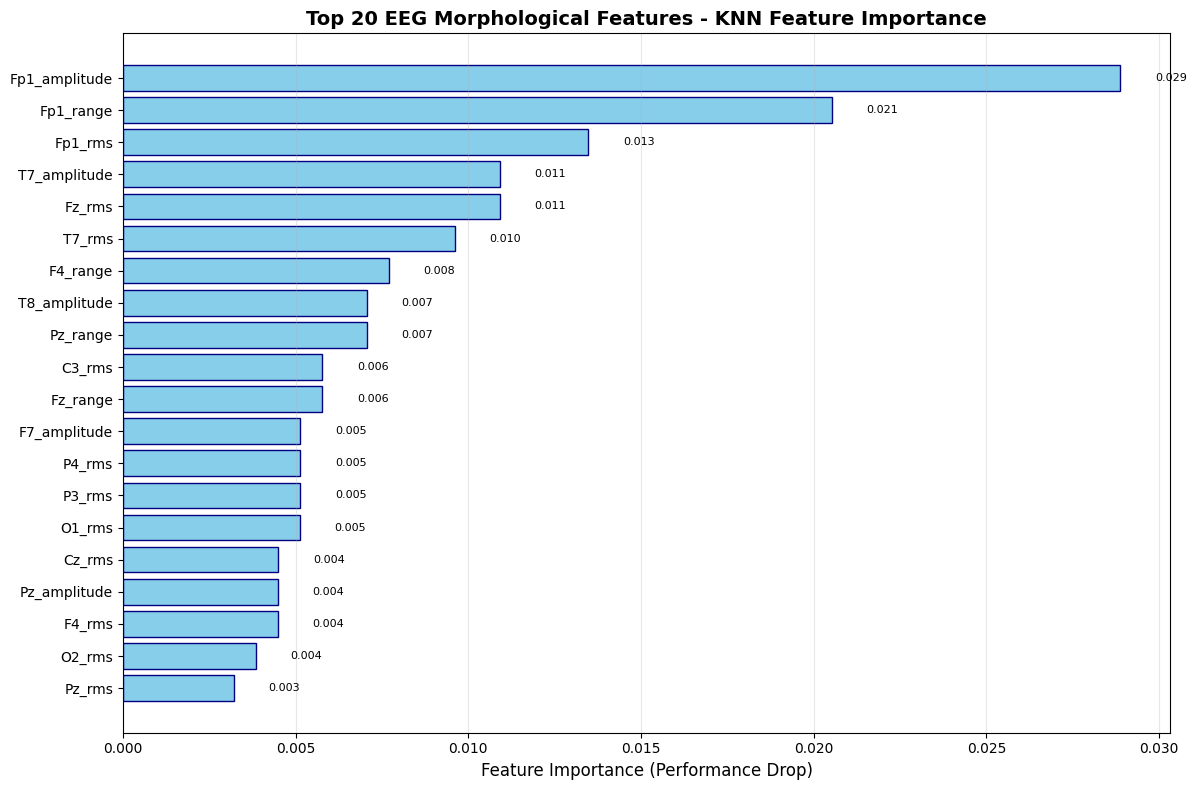


Top 10 Most Important Features:
--------------------------------------------------
 1. Fp1_amplitude: 0.0289
 2. Fp1_range: 0.0205
 3. Fp1_rms: 0.0135
 4. T7_amplitude: 0.0109
 5. Fz_rms: 0.0109
 6. T7_rms: 0.0096
 7. F4_range: 0.0077
 8. T8_amplitude: 0.0071
 9. Pz_range: 0.0071
10. C3_rms: 0.0058


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the CSV with extracted features
def load_and_process_data(csv_path):
    """Load CSV and prepare data for feature selection"""
    df = pd.read_csv(csv_path)

    # Remove any non-numeric columns or identifiers
    # Keep only the feature columns (assuming they're numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Fill any missing values
    X = X.fillna(X.mean())

    # Create synthetic target based on feature characteristics
    # (since no target provided, we'll use first feature median split)
    y = (X.iloc[:, 0] > X.iloc[:, 0].median()).astype(int)

    return X, y, numeric_cols

def knn_feature_importance(X, y, k=5):
    """Calculate feature importance using KNN-based method"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Base KNN performance
    knn = KNeighborsClassifier(n_neighbors=k)
    base_score = cross_val_score(knn, X_scaled, y, cv=3).mean()

    # Calculate importance by feature permutation
    importances = []
    feature_names = X.columns

    for i in range(X.shape[1]):
        # Create copy and permute feature i
        X_perm = X_scaled.copy()
        np.random.shuffle(X_perm[:, i])

        # Calculate performance drop
        perm_score = cross_val_score(knn, X_perm, y, cv=3).mean()
        importance = base_score - perm_score
        importances.append(importance)

    return np.array(importances), feature_names

def plot_feature_importance(importances, feature_names, top_n=20):
    """Plot feature importance graph"""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_names)), top_names, fontsize=10)
    plt.xlabel('Feature Importance (Performance Drop)', fontsize=12)
    plt.title('Top 20 EEG Morphological Features - KNN Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=8)

    plt.show()

    return top_names, top_importances

# Main execution
if __name__ == "__main__":
    # Load your CSV file
    csv_path = 'morphological_features_windowed.csv'  # Replace with your actual file path

    try:
        # Load and process data
        X, y, feature_names = load_and_process_data(csv_path)
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")

        # Calculate KNN-based feature importance
        print("Calculating KNN feature importance...")
        importances, feature_names = knn_feature_importance(X, y, k=5)

        # Plot results
        top_features, top_scores = plot_feature_importance(importances, feature_names)

        # Print summary
        print("\nTop 10 Most Important Features:")
        print("-" * 50)
        for i, (name, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"{i+1:2d}. {name}: {score:.4f}")

    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_path}'")
        print("Please update the csv_path variable with your actual file path")
    except Exception as e:
        print(f"Error: {e}")

# Alternative: If you want to use statistical F-test instead of KNN
def statistical_feature_selection(X, y, top_n=20):
    """Alternative method using F-test"""
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)

    # Get F-scores
    f_scores = selector.scores_
    feature_names = X.columns

    # Plot
    indices = np.argsort(f_scores)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), f_scores[indices], color='lightcoral', edgecolor='darkred')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('F-Score', fontsize=12)
    plt.title('Top 20 EEG Features - Statistical F-Test Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return [feature_names[i] for i in indices], f_scores[indices]

Data loaded: 1559 samples, 172 features
Calculating KNN feature importance...


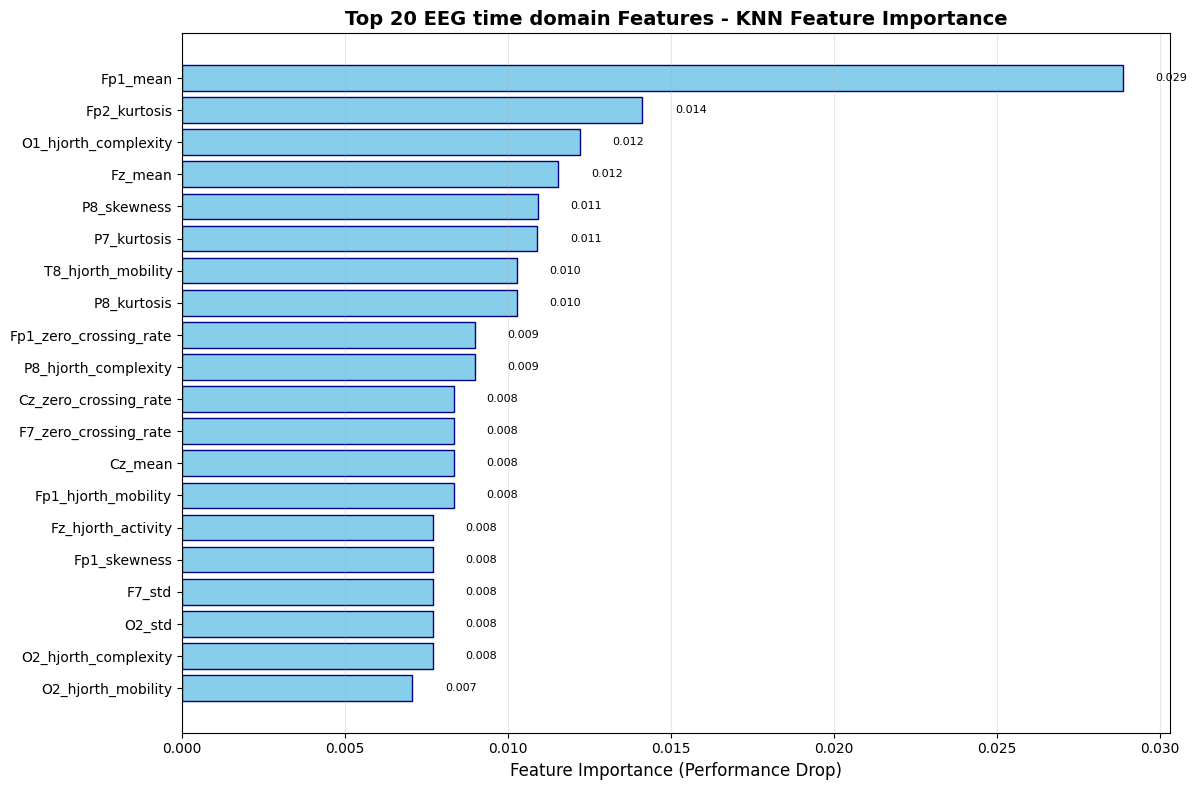


Top 10 Most Important Features:
--------------------------------------------------
 1. Fp1_mean: 0.0289
 2. Fp2_kurtosis: 0.0141
 3. O1_hjorth_complexity: 0.0122
 4. Fz_mean: 0.0115
 5. P8_skewness: 0.0109
 6. P7_kurtosis: 0.0109
 7. T8_hjorth_mobility: 0.0103
 8. P8_kurtosis: 0.0103
 9. Fp1_zero_crossing_rate: 0.0090
10. P8_hjorth_complexity: 0.0090


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the CSV with extracted features
def load_and_process_data(csv_path):
    """Load CSV and prepare data for feature selection"""
    df = pd.read_csv(csv_path)

    # Remove any non-numeric columns or identifiers
    # Keep only the feature columns (assuming they're numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Fill any missing values
    X = X.fillna(X.mean())

    # Create synthetic target based on feature characteristics
    # (since no target provided, we'll use first feature median split)
    y = (X.iloc[:, 0] > X.iloc[:, 0].median()).astype(int)

    return X, y, numeric_cols

def knn_feature_importance(X, y, k=5):
    """Calculate feature importance using KNN-based method"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Base KNN performance
    knn = KNeighborsClassifier(n_neighbors=k)
    base_score = cross_val_score(knn, X_scaled, y, cv=3).mean()

    # Calculate importance by feature permutation
    importances = []
    feature_names = X.columns

    for i in range(X.shape[1]):
        # Create copy and permute feature i
        X_perm = X_scaled.copy()
        np.random.shuffle(X_perm[:, i])

        # Calculate performance drop
        perm_score = cross_val_score(knn, X_perm, y, cv=3).mean()
        importance = base_score - perm_score
        importances.append(importance)

    return np.array(importances), feature_names

def plot_feature_importance(importances, feature_names, top_n=20):
    """Plot feature importance graph"""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_names)), top_names, fontsize=10)
    plt.xlabel('Feature Importance (Performance Drop)', fontsize=12)
    plt.title('Top 20 EEG time domain Features - KNN Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=8)

    plt.show()

    return top_names, top_importances

# Main execution
if __name__ == "__main__":
    # Load your CSV file
    csv_path = 'time_domain_features_windowed(1).csv'  # Replace with your actual file path

    try:
        # Load and process data
        X, y, feature_names = load_and_process_data(csv_path)
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")

        # Calculate KNN-based feature importance
        print("Calculating KNN feature importance...")
        importances, feature_names = knn_feature_importance(X, y, k=5)

        # Plot results
        top_features, top_scores = plot_feature_importance(importances, feature_names)

        # Print summary
        print("\nTop 10 Most Important Features:")
        print("-" * 50)
        for i, (name, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"{i+1:2d}. {name}: {score:.4f}")

    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_path}'")
        print("Please update the csv_path variable with your actual file path")
    except Exception as e:
        print(f"Error: {e}")

# Alternative: If you want to use statistical F-test instead of KNN
def statistical_feature_selection(X, y, top_n=20):
    """Alternative method using F-test"""
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)

    # Get F-scores
    f_scores = selector.scores_
    feature_names = X.columns

    # Plot
    indices = np.argsort(f_scores)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), f_scores[indices], color='lightcoral', edgecolor='darkred')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('F-Score', fontsize=12)
    plt.title('Top 20 EEG Features - Statistical F-Test Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return [feature_names[i] for i in indices], f_scores[indices]

Data loaded: 1559 samples, 229 features
Calculating KNN feature importance...


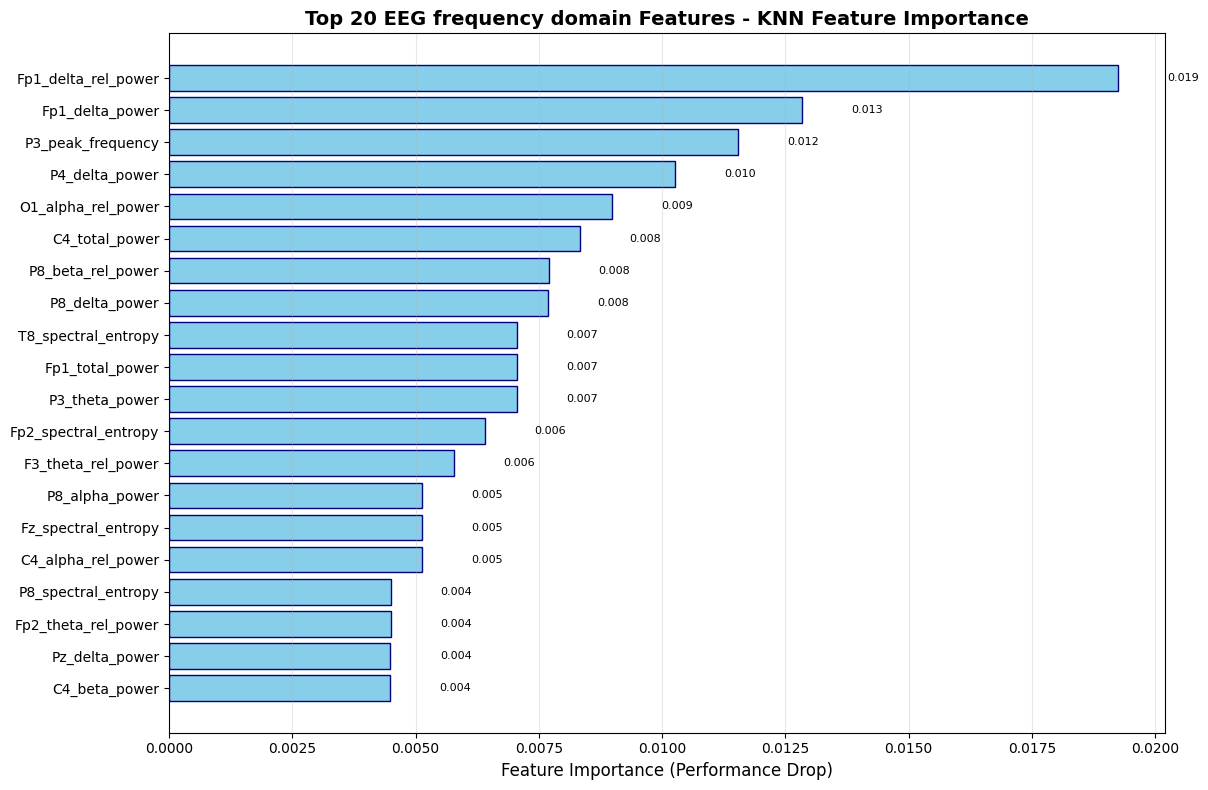


Top 10 Most Important Features:
--------------------------------------------------
 1. Fp1_delta_rel_power: 0.0192
 2. Fp1_delta_power: 0.0128
 3. P3_peak_frequency: 0.0115
 4. P4_delta_power: 0.0103
 5. O1_alpha_rel_power: 0.0090
 6. C4_total_power: 0.0083
 7. P8_beta_rel_power: 0.0077
 8. P8_delta_power: 0.0077
 9. T8_spectral_entropy: 0.0071
10. Fp1_total_power: 0.0071


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the CSV with extracted features
def load_and_process_data(csv_path):
    """Load CSV and prepare data for feature selection"""
    df = pd.read_csv(csv_path)

    # Remove any non-numeric columns or identifiers
    # Keep only the feature columns (assuming they're numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Fill any missing values
    X = X.fillna(X.mean())

    # Create synthetic target based on feature characteristics
    # (since no target provided, we'll use first feature median split)
    y = (X.iloc[:, 0] > X.iloc[:, 0].median()).astype(int)

    return X, y, numeric_cols

def knn_feature_importance(X, y, k=5):
    """Calculate feature importance using KNN-based method"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Base KNN performance
    knn = KNeighborsClassifier(n_neighbors=k)
    base_score = cross_val_score(knn, X_scaled, y, cv=3).mean()

    # Calculate importance by feature permutation
    importances = []
    feature_names = X.columns

    for i in range(X.shape[1]):
        # Create copy and permute feature i
        X_perm = X_scaled.copy()
        np.random.shuffle(X_perm[:, i])

        # Calculate performance drop
        perm_score = cross_val_score(knn, X_perm, y, cv=3).mean()
        importance = base_score - perm_score
        importances.append(importance)

    return np.array(importances), feature_names

def plot_feature_importance(importances, feature_names, top_n=20):
    """Plot feature importance graph"""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_names)), top_names, fontsize=10)
    plt.xlabel('Feature Importance (Performance Drop)', fontsize=12)
    plt.title('Top 20 EEG frequency domain Features - KNN Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=8)

    plt.show()

    return top_names, top_importances

# Main execution
if __name__ == "__main__":
    # Load your CSV file
    csv_path = 'frequency_domain_features_windowed_balanced.csv'  # Replace with your actual file path

    try:
        # Load and process data
        X, y, feature_names = load_and_process_data(csv_path)
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")

        # Calculate KNN-based feature importance
        print("Calculating KNN feature importance...")
        importances, feature_names = knn_feature_importance(X, y, k=5)

        # Plot results
        top_features, top_scores = plot_feature_importance(importances, feature_names)

        # Print summary
        print("\nTop 10 Most Important Features:")
        print("-" * 50)
        for i, (name, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"{i+1:2d}. {name}: {score:.4f}")

    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_path}'")
        print("Please update the csv_path variable with your actual file path")
    except Exception as e:
        print(f"Error: {e}")

# Alternative: If you want to use statistical F-test instead of KNN
def statistical_feature_selection(X, y, top_n=20):
    """Alternative method using F-test"""
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)

    # Get F-scores
    f_scores = selector.scores_
    feature_names = X.columns

    # Plot
    indices = np.argsort(f_scores)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), f_scores[indices], color='lightcoral', edgecolor='darkred')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('F-Score', fontsize=12)
    plt.title('Top 20 EEG Features - Statistical F-Test Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return [feature_names[i] for i in indices], f_scores[indices]

Data loaded: 1559 samples, 301 features
Calculating KNN feature importance...


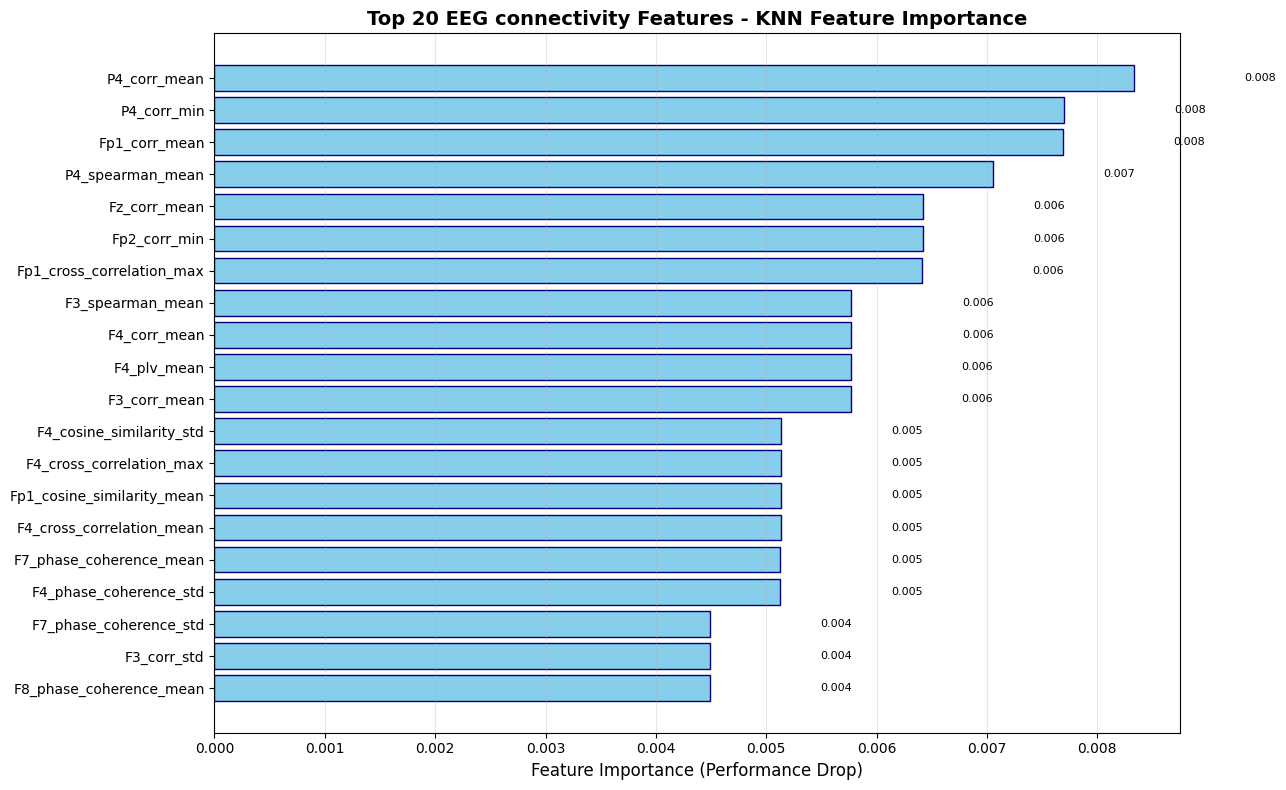


Top 10 Most Important Features:
--------------------------------------------------
 1. P4_corr_mean: 0.0083
 2. P4_corr_min: 0.0077
 3. Fp1_corr_mean: 0.0077
 4. P4_spearman_mean: 0.0071
 5. Fz_corr_mean: 0.0064
 6. Fp2_corr_min: 0.0064
 7. Fp1_cross_correlation_max: 0.0064
 8. F3_spearman_mean: 0.0058
 9. F4_corr_mean: 0.0058
10. F4_plv_mean: 0.0058


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the CSV with extracted features
def load_and_process_data(csv_path):
    """Load CSV and prepare data for feature selection"""
    df = pd.read_csv(csv_path)

    # Remove any non-numeric columns or identifiers
    # Keep only the feature columns (assuming they're numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Fill any missing values
    X = X.fillna(X.mean())

    # Create synthetic target based on feature characteristics
    # (since no target provided, we'll use first feature median split)
    y = (X.iloc[:, 0] > X.iloc[:, 0].median()).astype(int)

    return X, y, numeric_cols

def knn_feature_importance(X, y, k=5):
    """Calculate feature importance using KNN-based method"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Base KNN performance
    knn = KNeighborsClassifier(n_neighbors=k)
    base_score = cross_val_score(knn, X_scaled, y, cv=3).mean()

    # Calculate importance by feature permutation
    importances = []
    feature_names = X.columns

    for i in range(X.shape[1]):
        # Create copy and permute feature i
        X_perm = X_scaled.copy()
        np.random.shuffle(X_perm[:, i])

        # Calculate performance drop
        perm_score = cross_val_score(knn, X_perm, y, cv=3).mean()
        importance = base_score - perm_score
        importances.append(importance)

    return np.array(importances), feature_names

def plot_feature_importance(importances, feature_names, top_n=20):
    """Plot feature importance graph"""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_names)), top_names, fontsize=10)
    plt.xlabel('Feature Importance (Performance Drop)', fontsize=12)
    plt.title('Top 20 EEG connectivity Features - KNN Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=8)

    plt.show()

    return top_names, top_importances

# Main execution
if __name__ == "__main__":
    # Load your CSV file
    csv_path = 'per_channel_connectivity_features.csv'  # Replace with your actual file path

    try:
        # Load and process data
        X, y, feature_names = load_and_process_data(csv_path)
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")

        # Calculate KNN-based feature importance
        print("Calculating KNN feature importance...")
        importances, feature_names = knn_feature_importance(X, y, k=5)

        # Plot results
        top_features, top_scores = plot_feature_importance(importances, feature_names)

        # Print summary
        print("\nTop 10 Most Important Features:")
        print("-" * 50)
        for i, (name, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"{i+1:2d}. {name}: {score:.4f}")

    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_path}'")
        print("Please update the csv_path variable with your actual file path")
    except Exception as e:
        print(f"Error: {e}")

# Alternative: If you want to use statistical F-test instead of KNN
def statistical_feature_selection(X, y, top_n=20):
    """Alternative method using F-test"""
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)

    # Get F-scores
    f_scores = selector.scores_
    feature_names = X.columns

    # Plot
    indices = np.argsort(f_scores)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), f_scores[indices], color='lightcoral', edgecolor='darkred')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('F-Score', fontsize=12)
    plt.title('Top 20 EEG Features - Statistical F-Test Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return [feature_names[i] for i in indices], f_scores[indices]

Data loaded: 1559 samples, 757 features
Calculating KNN feature importance...


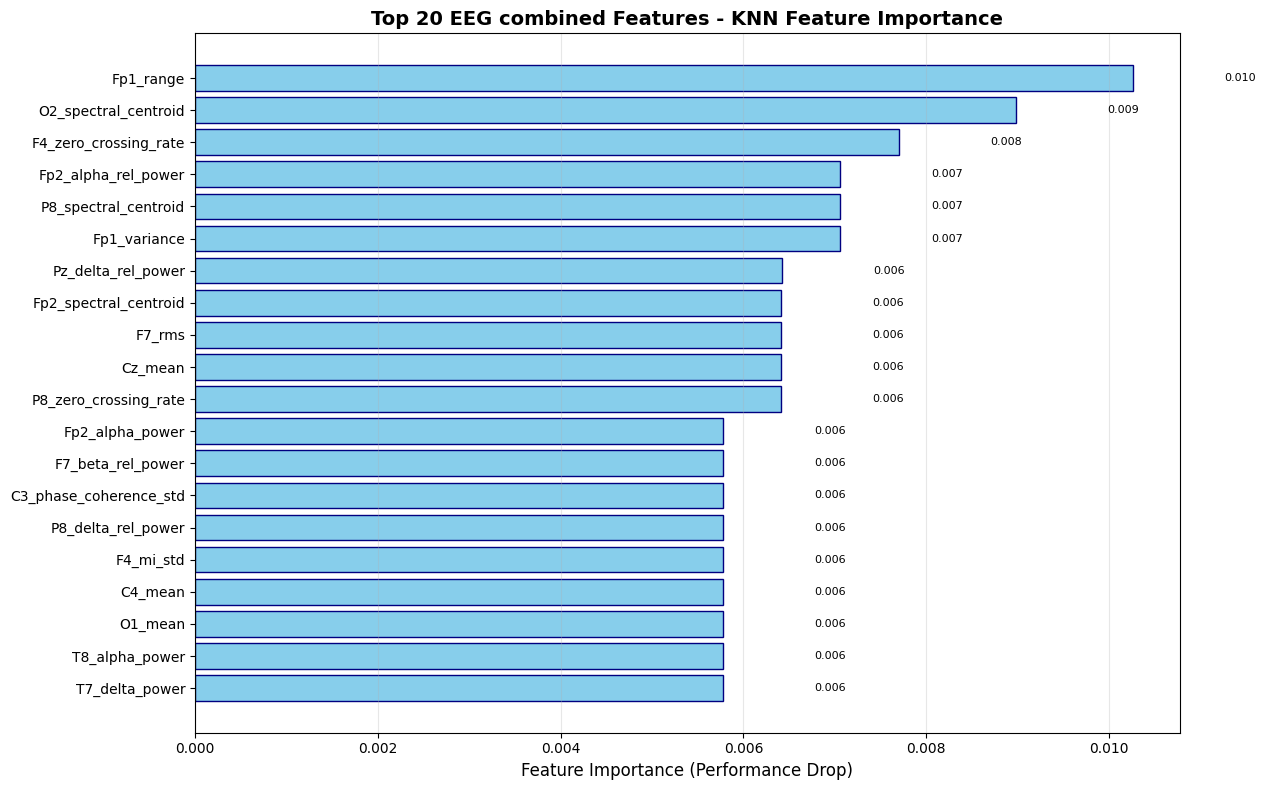


Top 10 Most Important Features:
--------------------------------------------------
 1. Fp1_range: 0.0103
 2. O2_spectral_centroid: 0.0090
 3. F4_zero_crossing_rate: 0.0077
 4. Fp2_alpha_rel_power: 0.0071
 5. P8_spectral_centroid: 0.0071
 6. Fp1_variance: 0.0071
 7. Pz_delta_rel_power: 0.0064
 8. Fp2_spectral_centroid: 0.0064
 9. F7_rms: 0.0064
10. Cz_mean: 0.0064


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load the CSV with extracted features
def load_and_process_data(csv_path):
    """Load CSV and prepare data for feature selection"""
    df = pd.read_csv(csv_path)

    # Remove any non-numeric columns or identifiers
    # Keep only the feature columns (assuming they're numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols]

    # Fill any missing values
    X = X.fillna(X.mean())

    # Create synthetic target based on feature characteristics
    # (since no target provided, we'll use first feature median split)
    y = (X.iloc[:, 0] > X.iloc[:, 0].median()).astype(int)

    return X, y, numeric_cols

def knn_feature_importance(X, y, k=5):
    """Calculate feature importance using KNN-based method"""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Base KNN performance
    knn = KNeighborsClassifier(n_neighbors=k)
    base_score = cross_val_score(knn, X_scaled, y, cv=3).mean()

    # Calculate importance by feature permutation
    importances = []
    feature_names = X.columns

    for i in range(X.shape[1]):
        # Create copy and permute feature i
        X_perm = X_scaled.copy()
        np.random.shuffle(X_perm[:, i])

        # Calculate performance drop
        perm_score = cross_val_score(knn, X_perm, y, cv=3).mean()
        importance = base_score - perm_score
        importances.append(importance)

    return np.array(importances), feature_names

def plot_feature_importance(importances, feature_names, top_n=20):
    """Plot feature importance graph"""
    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_names)), top_importances, color='skyblue', edgecolor='navy')
    plt.yticks(range(len(top_names)), top_names, fontsize=10)
    plt.xlabel('Feature Importance (Performance Drop)', fontsize=12)
    plt.title('Top 20 EEG combined Features - KNN Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=8)

    plt.show()

    return top_names, top_importances

# Main execution
if __name__ == "__main__":
    # Load your CSV file
    csv_path = 'combined_merged_data.csv'  # Replace with your actual file path

    try:
        # Load and process data
        X, y, feature_names = load_and_process_data(csv_path)
        print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")

        # Calculate KNN-based feature importance
        print("Calculating KNN feature importance...")
        importances, feature_names = knn_feature_importance(X, y, k=5)

        # Plot results
        top_features, top_scores = plot_feature_importance(importances, feature_names)

        # Print summary
        print("\nTop 10 Most Important Features:")
        print("-" * 50)
        for i, (name, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"{i+1:2d}. {name}: {score:.4f}")

    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_path}'")
        print("Please update the csv_path variable with your actual file path")
    except Exception as e:
        print(f"Error: {e}")

# Alternative: If you want to use statistical F-test instead of KNN
def statistical_feature_selection(X, y, top_n=20):
    """Alternative method using F-test"""
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)

    # Get F-scores
    f_scores = selector.scores_
    feature_names = X.columns

    # Plot
    indices = np.argsort(f_scores)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), f_scores[indices], color='lightcoral', edgecolor='darkred')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('F-Score', fontsize=12)
    plt.title('Top 20 EEG Features - Statistical F-Test Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return [feature_names[i] for i in indices], f_scores[indices]

In [ ]:
import pandas as pd

# --- 1. Define File Paths ---
# Replace with the actual paths to your CSV files
file1_path = 'eeg_preprocessed_data.csv'  # The file with the 'class' column
file2_path = 'per_channel_connectivity_features.csv' # The file with 'target', 'target_label', etc.
output_path = 'combined_merged_data.csv'             # The name for the final merged file

# --- 2. Load the CSV Files ---
try:
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    print("✅ Files loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error: {e}. Please check your file paths.")
    exit()

# --- 3. Merge the DataFrames ---
# Since they have the same number of rows, we can join them side-by-side (axis=1)
merged_df = pd.concat([df1, df2], axis=1)
print(f"Original merged shape: {merged_df.shape}")
print("Columns:", merged_df.columns.tolist())

# --- 4. Handle Redundant Columns ---
# The columns 'class', 'target', and 'target_label' likely represent the same information.
# We will keep 'target_label' as it is the most descriptive and drop the others.
columns_to_drop = []
if 'class' in merged_df.columns:
    columns_to_drop.append('class')
if 'target' in merged_df.columns:
    columns_to_drop.append('target')

if columns_to_drop:
    merged_df = merged_df.drop(columns=columns_to_drop)
    print(f"Dropped redundant columns: {columns_to_drop}")
else:
    print("No redundant 'class' or 'target' columns found to drop.")


# --- 5. Save the Final DataFrame ---
merged_df.to_csv(output_path, index=False)

print("\n🎉 Merge complete!")
print(f"Final shape: {merged_df.shape}")
print("Final Columns:", merged_df.columns.tolist())
print(f"Merged file saved to: {output_path}")

✅ Files loaded successfully.
Original merged shape: (1559, 760)
Columns: ['Fp1_amplitude', 'Fp1_range', 'Fp1_rms', 'Fp1_mean', 'Fp1_variance', 'Fp1_std', 'Fp1_skewness', 'Fp1_kurtosis', 'Fp1_hjorth_activity', 'Fp1_hjorth_mobility', 'Fp1_hjorth_complexity', 'Fp1_zero_crossing_rate', 'Fp1_delta_power', 'Fp1_theta_power', 'Fp1_alpha_power', 'Fp1_beta_power', 'Fp1_total_power', 'Fp1_delta_rel_power', 'Fp1_theta_rel_power', 'Fp1_alpha_rel_power', 'Fp1_beta_rel_power', 'Fp1_spectral_entropy', 'Fp1_peak_frequency', 'Fp1_spectral_centroid', 'Fp2_amplitude', 'Fp2_range', 'Fp2_rms', 'Fp2_mean', 'Fp2_variance', 'Fp2_std', 'Fp2_skewness', 'Fp2_kurtosis', 'Fp2_hjorth_activity', 'Fp2_hjorth_mobility', 'Fp2_hjorth_complexity', 'Fp2_zero_crossing_rate', 'Fp2_delta_power', 'Fp2_theta_power', 'Fp2_alpha_power', 'Fp2_beta_power', 'Fp2_total_power', 'Fp2_delta_rel_power', 'Fp2_theta_rel_power', 'Fp2_alpha_rel_power', 'Fp2_beta_rel_power', 'Fp2_spectral_entropy', 'Fp2_peak_frequency', 'Fp2_spectral_centroi